In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

students = pd.read_csv('stud_math.xls')

In [84]:
display(students.head(5))


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


# Предобработка

In [85]:
DEBUG = False
''' Вывод табицы с отбором по колонке и ее пустым значениям'''
def show_nan_value(column):    
    display(students[students[column].isnull().values][:])

''' Статистика колонки: квартили, границы выбросов'''    
def stat_column(column):
    perc25 = students[column].quantile(0.25)
    perc75 = students[column].quantile(0.75)
    IQR = perc75 - perc25
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    students[column].loc[students[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR')
    
''' Анализ колонки '''
def analis_column(column):
    students[column] = students[column].apply(lambda x: None if x == 'nan'  else x)
    if DEBUG:
        #students.drop(students[(students.score == 0) | (students['score'].isnull())].index, inplace=True)        
        display(students[column].value_counts())
        
    # замена на медиану пустых значений
    is_null = students[column].isnull().sum()
    if is_null>0:
        print(f'Пустых значений в {column}: {is_null}, Требуется замена')        
        #: {students[column].median()}'
        #students.score.hist()
    display(students[column].unique())    
    display(students.loc[:, [column]].info())
    display(students[column].describe())
    students[column].hist()

'''Заполнение пустых значении равномерным распределением'''
def division_column(column):

    df = students[column].value_counts().to_frame()
    # шаг для заполнения  равен пустые значения/количество значений в колонке
    is_null = students[column].isnull().sum()    
    step = round(is_null/len(df),0)
    if DEBUG: print(f'нулевых:{is_null} шаг:{step}')
    last_idx = None
    for idx, str_df in df.iterrows():
        counter = 0
        for index, str_stud in students[students[column].isnull()].iterrows():
            if counter < step:
                counter += 1
                students.loc[index, column] = idx            
                last_idx = idx
            else: break
    
    is_null = students[column].isnull().sum()
    if is_null > 0:
        for index, str_stud in students[students[column].isnull()].iterrows():
            students.loc[index, column] = last_idx            
    
    if DEBUG: print(f'нулевых:{is_null}')


In [86]:
# анализ колонок
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Удаляем колонку без описания "studytime, granular"

In [87]:
students.drop(['studytime, granular'], inplace = True, axis = 1)

 В сете содержится 395 строк. Наихудший результат заполнения в колонке Pstatus- 11,4% пустых значений. Так как 
предпологаем подготовку данных под алгоритм обучения с учителем, все данные должны быть не пустыми. Стратегия заполнения по медиане.
 Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Тоесть нельзя считать выбросом 0 значения score и пустые значения. Заполняем пустые score по медиане.
 

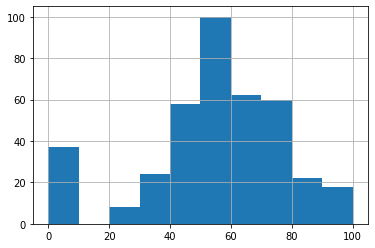

In [88]:
students.score.hist()

 Влияние на обучение не окажут пустые или нулевые данные score. Так как это личные обстоятельства или несчастные случаи.
Эти строки удаляю и считаю выбросом. Не пришли на экзамен 10.88% учеников.Средний бал 57, медиана 55, максимум 100.

Пустых значений в score: 6, Требуется замена


array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan,  20.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

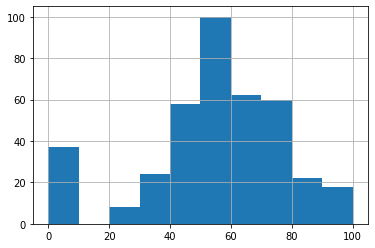

In [89]:
analis_column('score')


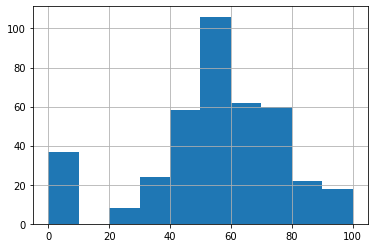

In [90]:
#удаление выбросов
students.loc[(students['score'].isnull()), ('score')] = students.score.median()

if DEBUG:
    #students.drop(students[(students.score == 0) | (students['score'].isnull())].index, inplace=True)
    display(students[students['score'].isnull().values][:])
    students.loc[:, ['score']].info()
    display(students.score.value_counts())
    display(students.score.unique())

students.score.hist()

school оставляем без изменений, все строки заполнены 

array(['GP', 'MS'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

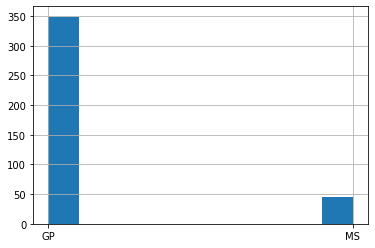

In [91]:
analis_column('school')

sex оставляем без изменений, все строки заполнены.

array(['F', 'M'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

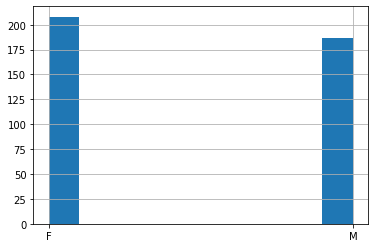

In [92]:
analis_column('sex')

Есть выброс по age 22 года 1 человек, незначительное отклонение, оставляем

array([18, 17, 15, 16, 19, 22, 20, 21], dtype=int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


None

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


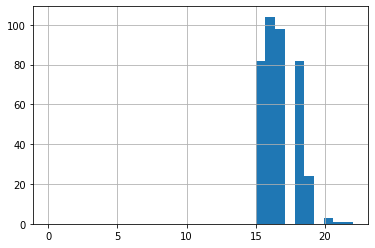

In [93]:

analis_column('age')
stat_column('age')

В адресе 14 пустых значений, заполняем по времени доступа к школе, меньше часа город иначе за городом

Пустых значений в address: 17, Требуется замена


array(['U', nan, 'R'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     378
unique      2
top         U
freq      295
Name: address, dtype: object

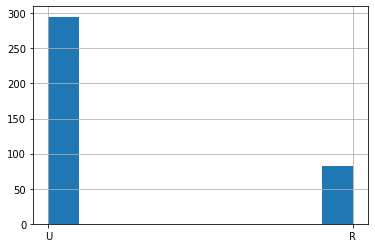

In [94]:
analis_column('address')
#stat_column('age')

# 'U' - городской, 'R' - за городом
students.loc[(students.traveltime  < 3)&(students.address.isnull()), ('address')] = 'U'
students.loc[(students.traveltime  >= 3)&(students.address.isnull()), ('address')] = 'R'


famsize имеет 27 пустых значений. Нет вспомогательных данных для заполнения, поэтому заполняем равномерно по значениям.

Пустых значений в famsize: 27, Требуется замена


array([nan, 'GT3', 'LE3'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

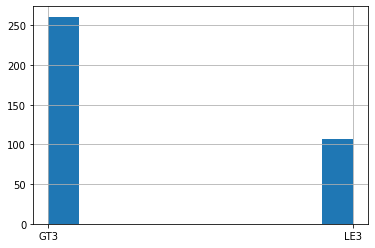

In [95]:
analis_column('famsize')
#stat_column('age')

In [96]:
#('LE3' <= 3, 'GT3' >3)
counter_col = 0
for index, str_df in students[students.famsize.isnull()].iterrows():
        
        if counter_col <=13:            
            students.loc[index, 'famsize'] = 'LE3'            
            counter_col+=1
        else:
            students.loc[index, 'famsize'] = 'GT3'


Pstatus имеет 45 пустых значений. Нет вспомогательных данных для заполнения, поэтому заполняем равномерно по значениям.

Пустых значений в Pstatus: 45, Требуется замена


array(['A', nan, 'T'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     350
unique      2
top         T
freq      314
Name: Pstatus, dtype: object

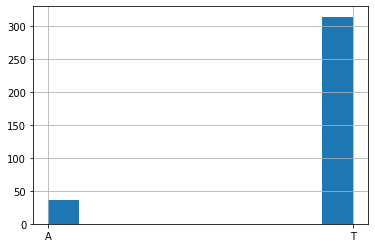

In [97]:
analis_column('Pstatus')


In [98]:
counter_col = 0
for index, str_df in students[students.Pstatus.isnull()].iterrows():
        
        if counter_col <=23:            
            students.loc[index, 'Pstatus'] = 'A'            
            counter_col+=1
        else:
            students.loc[index, 'Pstatus'] = 'T'
students.Pstatus.unique()

array(['A', 'T'], dtype=object)

# Medu есть пустые значения, меняем на медиану

Пустых значений в Medu: 3, Требуется замена


array([ 4.,  1.,  3.,  2., nan,  0.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

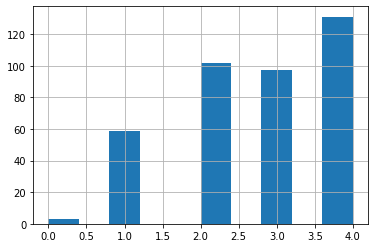

In [99]:
analis_column('Medu')
division_column('Medu')

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


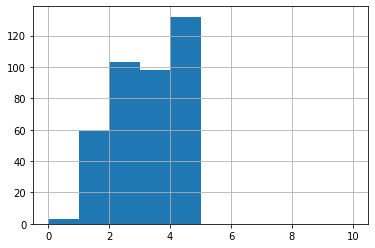

In [100]:
counter_col = 0
for index, str_df in students[students.Medu.isnull()].iterrows():
        
        students.loc[index, 'Medu'] = students.Medu.median()
        
stat_column('Medu')

Fedu пустые значения меняем на медиану, есть выброс со значением 40, меняем его на 4

Пустых значений в Fedu: 24, Требуется замена


array([ 4.,  1.,  2.,  3., 40., nan,  0.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


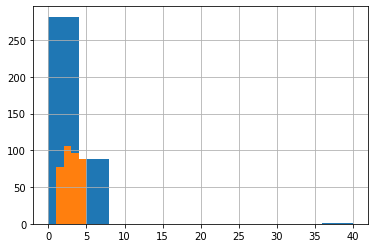

In [101]:
analis_column('Fedu')
stat_column('Fedu')

# изменение выброса
students.loc[(students.Fedu == 40), 'Fedu'] = 4

# равномерное распределение пустых значений
division_column('Fedu')

# заполнение медианой
#for index, str_df in students[students.Fedu.isnull()].iterrows():
        
 #       students.loc[index, 'Fedu'] = students.Fedu.median()


array([4., 1., 2., 3., 0.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fedu    395 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    395.000000
mean       2.491139
std        1.113734
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


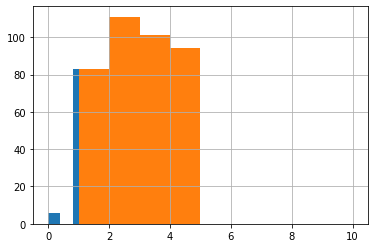

In [102]:
analis_column('Fedu')
stat_column('Fedu')

Пустых значений в Mjob: 19, Требуется замена


array(['at_home', 'health', 'other', 'services', 'teacher', nan],
      dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count       376
unique        5
top       other
freq        133
Name: Mjob, dtype: object

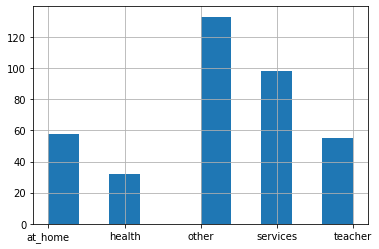

In [103]:
analis_column('Mjob')
#stat_column('Mjob')
# равномерное распределение пустых значений
division_column('Mjob')


Пустых значений в Fjob: 36, Требуется замена


array(['teacher', 'other', nan, 'health', 'services', 'at_home'],
      dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count       359
unique        5
top       other
freq        197
Name: Fjob, dtype: object

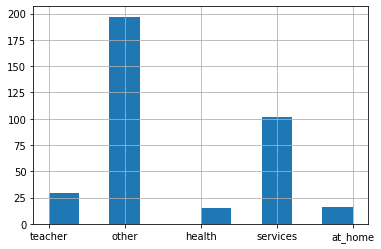

In [104]:

analis_column('Fjob')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('Fjob')


Пустых значений в reason: 17, Требуется замена


array(['course', 'other', 'home', 'reputation', nan], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

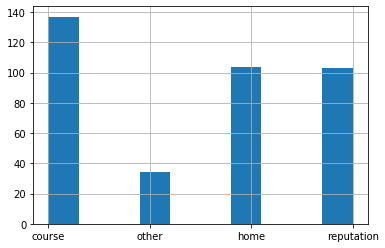

In [105]:
analis_column('reason')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('reason')



Пустых значений в guardian: 31, Требуется замена


array(['mother', 'father', 'other', nan], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

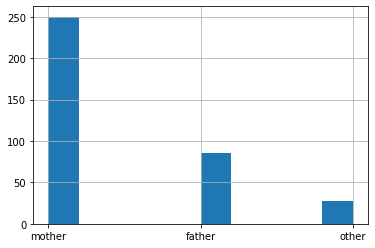

In [106]:
analis_column('guardian')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('guardian')


Пустых значений в traveltime: 28, Требуется замена


array([ 2.,  1.,  3., nan,  4.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

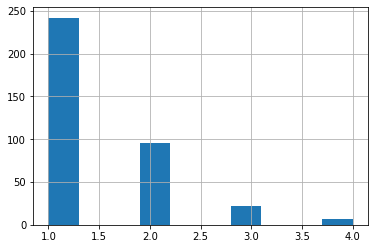

In [107]:
analis_column('traveltime')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('traveltime')

Пустых значений в studytime: 7, Требуется замена


array([ 2.,  3.,  1., nan,  4.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

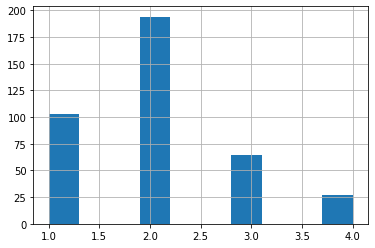

In [108]:
analis_column('studytime')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('studytime')

Пустых значений в failures: 22, Требуется замена


array([ 0.,  3., nan,  2.,  1.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  373 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

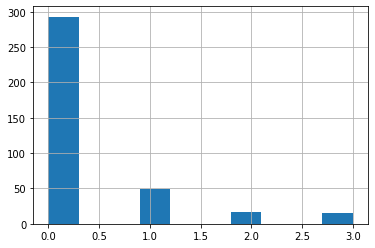

In [109]:
analis_column('failures')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('failures')

Пустых значений в schoolsup: 9, Требуется замена


array(['yes', 'no', nan], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     386
unique      2
top        no
freq      335
Name: schoolsup, dtype: object

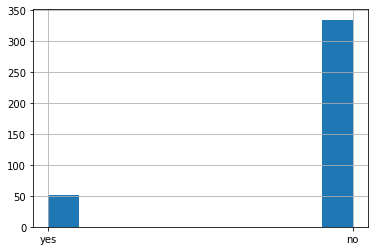

In [110]:
analis_column('schoolsup')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('schoolsup')

Пустых значений в famsup: 39, Требуется замена


array(['no', 'yes', nan], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

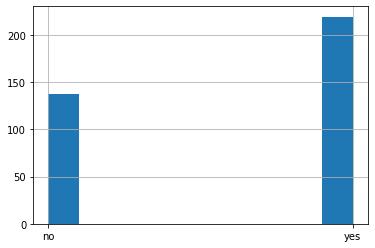

In [111]:
analis_column('famsup')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('famsup')


Пустых значений в paid: 40, Требуется замена


array(['no', nan, 'yes'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

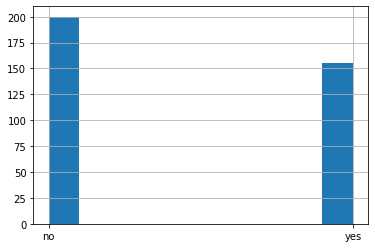

In [112]:
analis_column('paid')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('paid')

Пустых значений в activities: 14, Требуется замена


array(['no', 'yes', nan], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

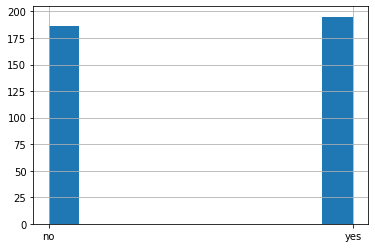

In [113]:
analis_column('activities')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('activities')

Пустых значений в nursery: 16, Требуется замена


array(['yes', 'no', nan], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

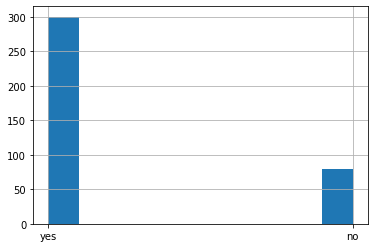

In [114]:
analis_column('nursery')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('nursery')

Пустых значений в higher: 20, Требуется замена


array(['yes', nan, 'no'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

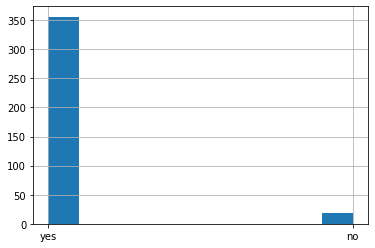

In [115]:
analis_column('higher')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('higher') 

Пустых значений в internet: 34, Требуется замена


array([nan, 'yes', 'no'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

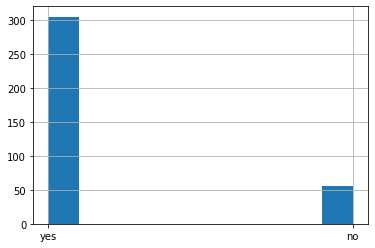

In [116]:
analis_column('internet')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('internet')

Пустых значений в romantic: 31, Требуется замена


array(['no', nan, 'yes'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

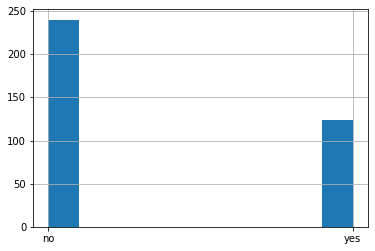

In [117]:
analis_column('romantic')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('romantic')

Пустых значений в famrel: 27, Требуется замена


array([ 4.,  5.,  3., nan, -1.,  2.,  1.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  368 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

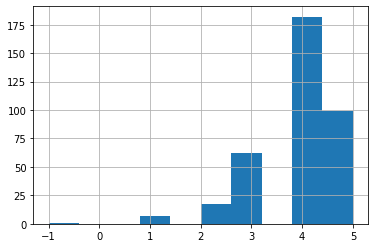

In [118]:
analis_column('famrel')
#stat_column('Fjob')
# равномерное распределение пустых значений
#division_column('famrel')

Famrel - есть выброс -1 меняю на None и с другими пустыми значениями равномерно распределяю по значениям

In [119]:
# изменение выброса
students.loc[(students.famrel == -1), 'famrel'] = None

# равномерное распределение пустых значений
division_column('famrel')



Пустых значений в freetime: 11, Требуется замена


array([ 3.,  2.,  4.,  1.,  5., nan])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  384 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

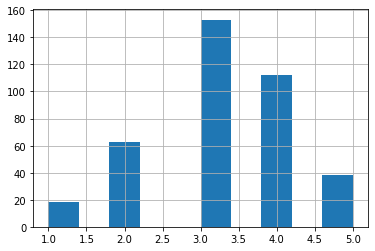

In [120]:
analis_column('freetime')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('famrel')

Пустых значений в goout: 8, Требуется замена


array([ 4.,  3.,  2.,  1.,  5., nan])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   387 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

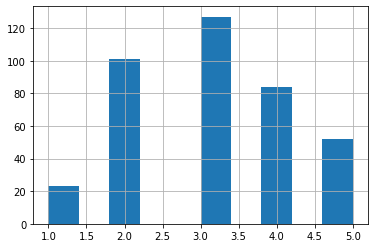

In [121]:
analis_column('goout')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('goout')

Пустых значений в health: 15, Требуется замена


array([ 3.,  5.,  1.,  2.,  4., nan])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

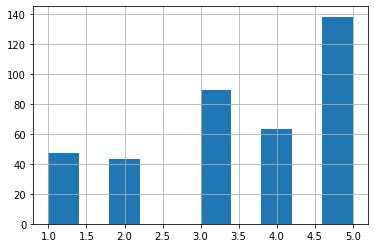

In [122]:
analis_column('health')
#stat_column('Fjob')
# равномерное распределение пустых значений
division_column('health')

Пустых значений в absences: 12, Требуется замена


array([  6.,   4.,  10.,   2.,   0.,  16.,  nan,  14.,   7.,   8.,  25.,
        12.,  54.,  18.,  26.,  20.,  56.,  24.,  28.,   5.,  13.,  15.,
        22.,   3., 385.,  21.,   1.,  75.,  30.,  19.,   9.,  11.,  38.,
        40.,  23.,  17., 212.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  383 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

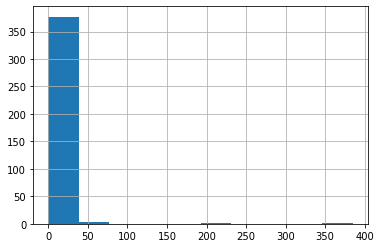

In [123]:
analis_column('absences')
#stat_column('Fjob')
# равномерное распределение пустых значений
#division_column('absences')

выбросы заменяю на пустые значения и заполняю медианой

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


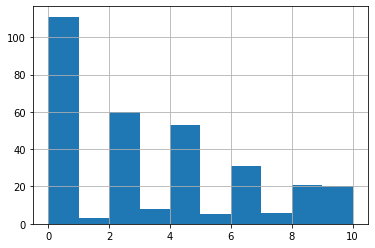

In [124]:
stat_column('absences')

In [125]:
# изменение выброса
students.loc[(students.absences >= 20), 'absences'] = None

# заполнение пустых значений медианой
students.loc[(students.absences.isnull()), 'absences'] = students.absences.median()

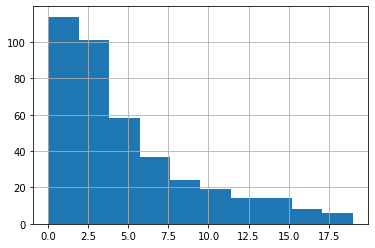

In [126]:
students.absences.hist()

Проведем анализ корреляции

In [127]:
students.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.161034,-0.180489,0.131498,0.000387,0.227123,-0.016157,0.029023,0.143607,-0.080436,0.110820,-0.151150
Medu,-0.161034,1.000000,0.561436,-0.167737,0.066230,-0.203306,-0.008288,0.025940,0.054205,-0.047742,0.087162,0.203098
Fedu,-0.180489,0.561436,1.000000,-0.162413,0.004444,-0.218154,-0.015201,-0.021713,0.005912,0.012676,-0.024573,0.098490
traveltime,0.131498,-0.167737,-0.162413,1.000000,-0.091070,0.104794,-0.025208,-0.029104,0.028696,0.023623,-0.047065,-0.108884
studytime,0.000387,0.066230,0.004444,-0.091070,1.000000,-0.148791,0.033926,-0.116206,-0.048138,-0.112829,-0.051798,0.110187
failures,0.227123,-0.203306,-0.218154,0.104794,-0.148791,1.000000,0.031827,0.069462,0.094306,0.057115,0.048968,-0.301049
famrel,-0.016157,-0.008288,-0.015201,-0.025208,0.033926,0.031827,1.000000,0.113808,0.023268,0.069209,-0.074298,0.056273
freetime,0.029023,0.025940,-0.021713,-0.029104,-0.116206,0.069462,0.113808,1.000000,0.294592,0.048746,0.087307,0.019932
goout,0.143607,0.054205,0.005912,0.028696,-0.048138,0.094306,0.023268,0.294592,1.000000,-0.001643,0.112138,-0.130191
health,-0.080436,-0.047742,0.012676,0.023623,-0.112829,0.057115,0.069209,0.048746,-0.001643,1.000000,-0.006559,-0.060584


Вывод
Наиболее значимыми для оценки (score) в порядке убывания являются значения: 
    Medu, studytime, Fedu, absences, famrel, freetime.
Остальные значения можно не использовать для анализа.
Максимальное значение корреляции 0.2, этого не достаточно для предсказания оценки экзамена.


In [128]:
#students.drop(['age', 'traveltime', 'failures', 'goout', 'health'], inplace = True, axis = 1)

In [129]:
#sns.pairplot(students, kind = 'reg')

In [130]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (10, 3))
    sns.boxplot(x=column, y='score', 
                data=students.loc[students.loc[:, column].isin(students.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [131]:
students.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

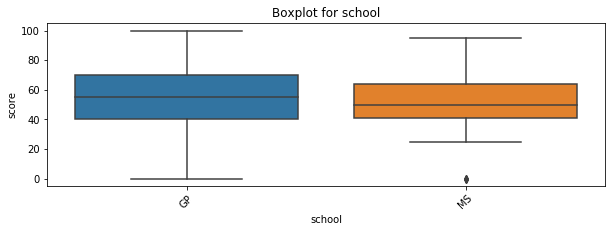

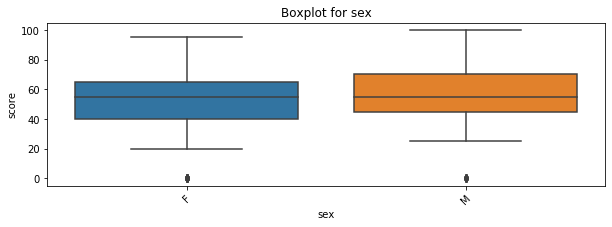

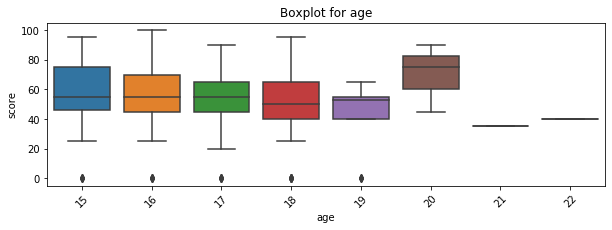

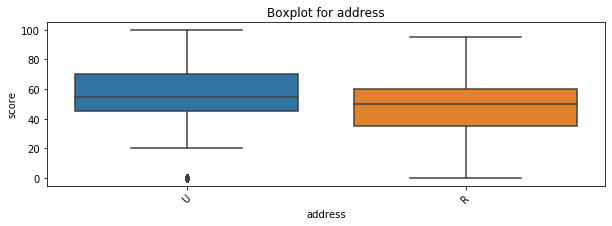

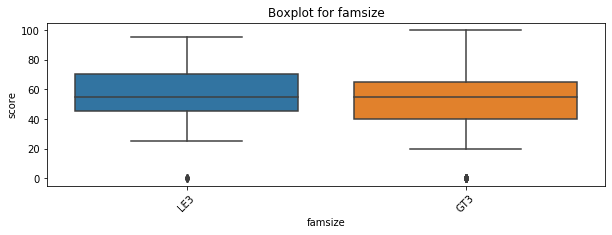

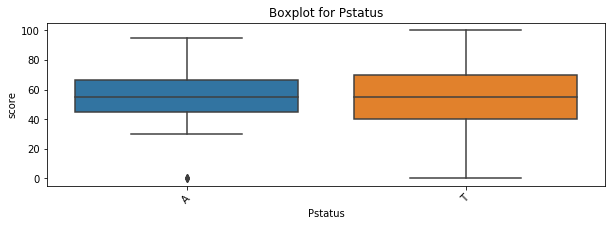

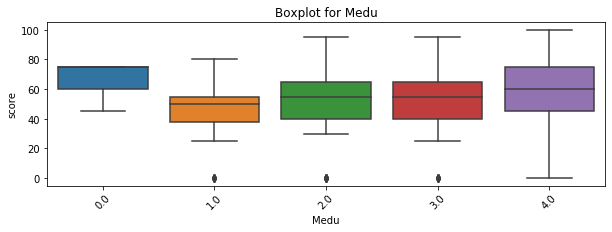

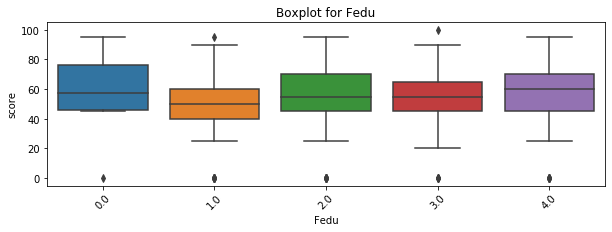

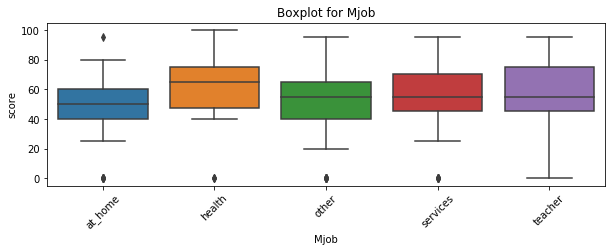

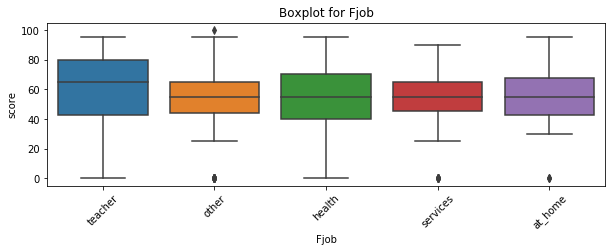

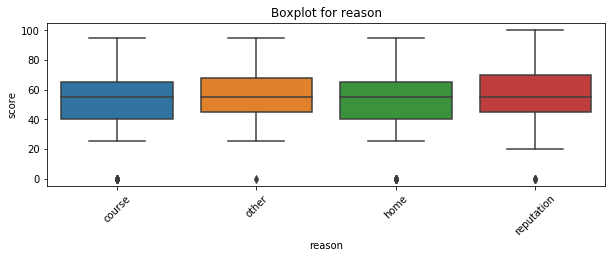

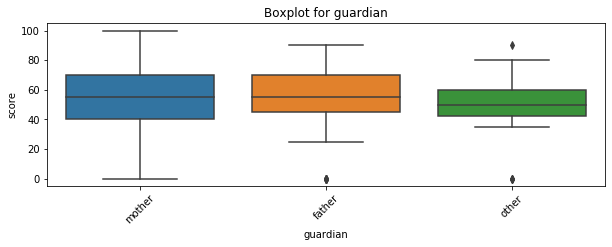

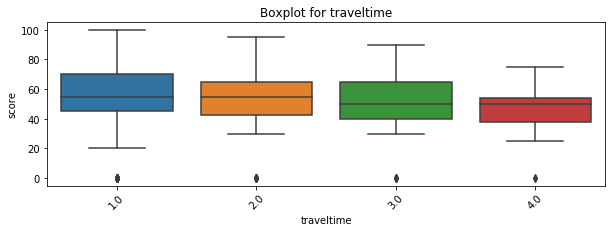

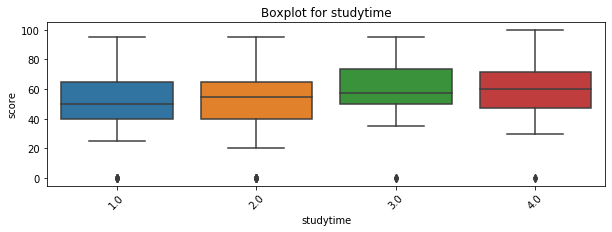

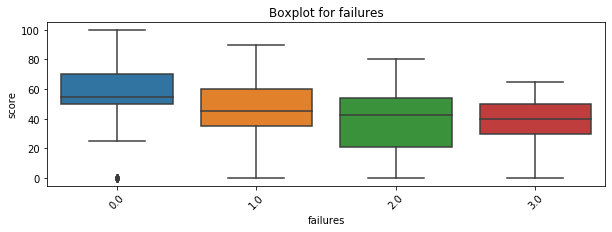

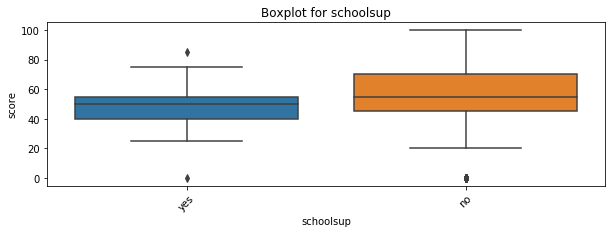

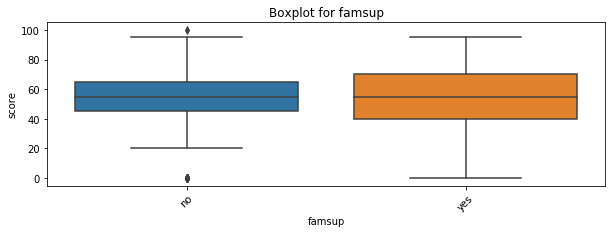

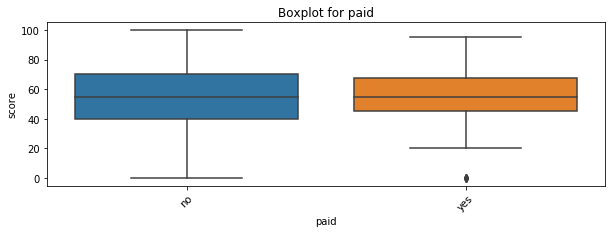

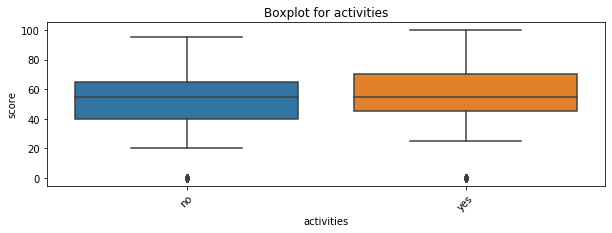

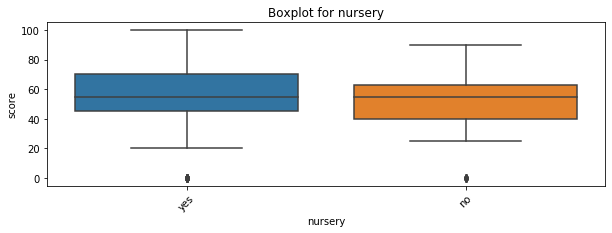

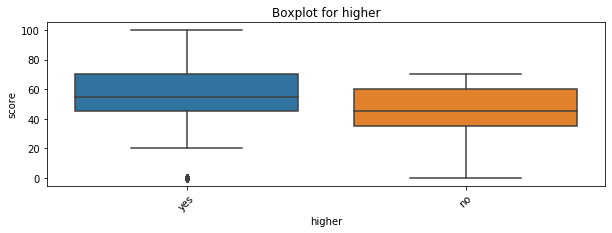

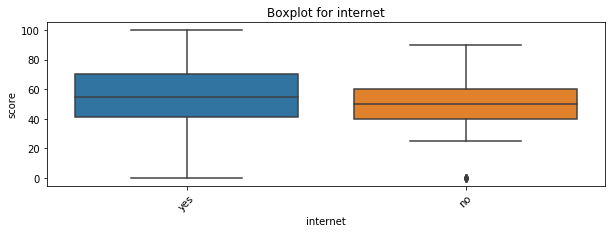

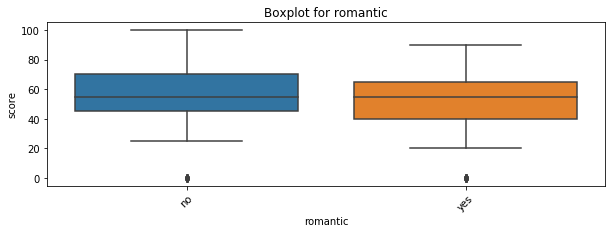

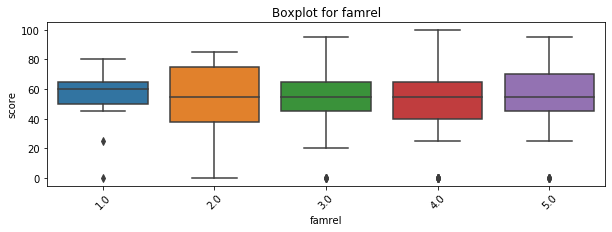

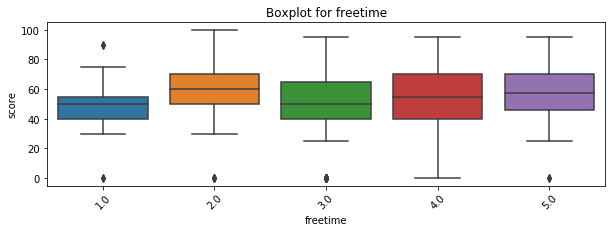

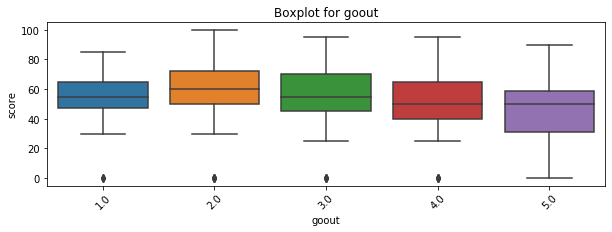

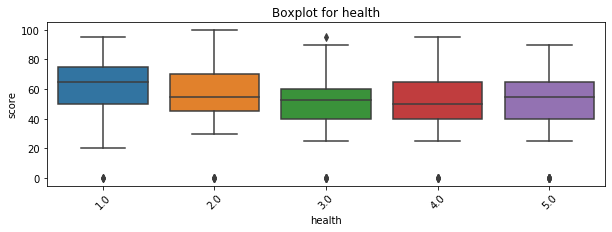

In [132]:
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health']:
    get_boxplot(col)

Визуальный анализ номинативных данных показывает влияние данных на оценку(score). Несмотря на примерно одинаковые медианы в распределении данных, видно смещение выборки к лучшим оценкам у тех кто больше уделяет времени учебе и имеет ресурсы для обчения: быстрее добирается до школы(адрес), не имеет романтических отношений, имеет интернет, строит планы на будущее высшее образование, имеет родителей с лучшим образованием и работой, возможность выбрать школу по рейтингу.


In [133]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                        students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health']:
    get_stat_dif(col)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


 Статистический анализ выделил колонки выше, результат совпадает с корреляционным анализом.
 Самая интересная колонка schoolsup, несмотря на дополнительные занятия,
баллы выше при отсутствии поддержки. Вероятно без внутренней мотивации результат обучения посредственный.